# An application to mango patchiness analysis

In [13]:
import matplotlib
%matplotlib nbagg
from matplotlib import pyplot

In [14]:
import os
figure = os.environ.get('FIGURE', 'svg')

In [15]:
from statiskit import (linalg,
                       core)

In [16]:
from statiskit.data import core as data
data = data.load('FPD17')

In [17]:
pi = [1.] * len(data.components)
components = [core.SplittingDistribution(core.PoissonDistribution(1.),
                                         core.MultinomialSplittingOperator(linalg.Vector(pi)))]
for x in [1.1, 1.2, 1.3, 1.4]:
    for index in range(len(data.components)):
        pi = [1.] * len(data.components)
        pi[index] = x
        components.append(core.SplittingDistribution(core.PoissonDistribution(x),
                                                     core.MultinomialSplittingOperator(linalg.Vector(pi))))

In [18]:
initializator = core.MixtureDistribution(*components,
                                         pi = linalg.Vector([1.] * len(components)))

In [19]:
estimator = core.shifted_estimation(core.outcome_type.DISCRETE,
                                    shift = 1,
                                    estimator = core.selection(core.outcome_type.DISCRETE,
                                                               estimators = [core.poisson_estimation('ml'),
                                                                             core.binomial_estimation('ml'),
                                                                             core.negative_binomial_estimation('ml')]))
estimator = core.selection(core.outcome_type.DISCRETE,
                           estimators = [estimator,
                                         core.geometric_estimation('ml'),
                                         core.logarithmic_estimation('ml')])

In [20]:
estimator = core.splitting_estimation(sum = estimator,
                                      splitting = core.splitting_selection('MN',
                                                                           'DM'))

In [ ]:
results = [core.mixture_estimation(data, 'em',
                                   initializator = initializator,
                                   default_estimator = estimator)]

In [10]:
import math
def compute_norm(p,q):
    sum = 0.
    for i in range(len(p)):
        sum += p[i] * math.log(p[i] / q[i]) + q[i] * math.log(q[i] / p[i])
    return sum

In [11]:
while len(components) > 2:
    argmin = None
    mini = float("inf")
    for i in range(results[-1].estimated.nb_states):
        for j in range(i + 1, results[-1].estimated.nb_states):
            norm = compute_norm(results[-1].estimated.observations[i].pi, results[-1].estimated.observations[j].pi)
            if norm < mini:
                mini = norm
                if results[-1].estimated.pi[i] > results[-1].estimated.pi[j]:
                    argmin = j
                else:
                    argmin = i
    components.pop(min(argmin, len(components) - 1))
    initializator = core.MixtureDistribution(*components,
                                             pi = linalg.Vector([1.] * len(components)))
    results.append(core.mixture_estimation(data, 'em',
                                           initializator = initializator,
                                           default_estimator=estimator,
                                           minits=80))

In [12]:
results.append(estimator(data, False))
results = list(reversed(results))

In [13]:
import math
S = [result.estimated.loglikelihood(data) for result in results]
U = [0] + [result.estimated.uncertainty(data) for result in results[1:]]
D = [results[0].estimated.nb_parameters] + [result.estimated.nb_parameters for result in results[1:]]
BIC = [2 * s - d * math.log(data.total) for s, d in zip(S, D)]
C = [1] + [result.estimated.nb_states for result in results[1:]]

<IPython.core.display.Javascript object>


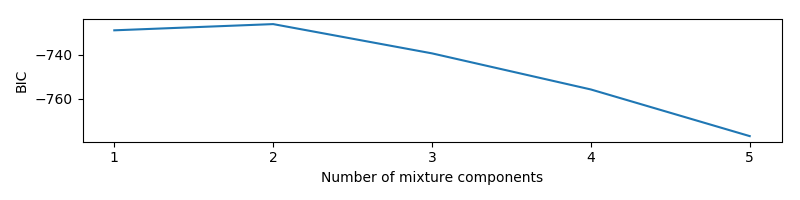

In [14]:
limit = 5
fig = pyplot.figure(figsize=(8,2))
axes = fig.add_subplot(111)
axes.plot(C[:limit], BIC[:limit], color='#e6e6e6')
axes.set_xticks(range(1, limit + 1))
axes.set_xlabel('Number of mixture components')
axes.set_ylabel('BIC')
pyplot.tight_layout()
fig.savefig('selection.' + figure)

<IPython.core.display.Javascript object>


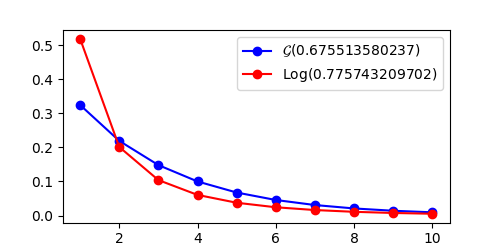

In [15]:
fig = pyplot.figure(figsize=(5,2.5))
axes = results[1].estimated.observations[0].sum.pdf_plot(color = 'b', fmt = 'o-', label=results[1].estimated.observations[0].sum._repr_latex_())
results[1].estimated.observations[1].sum.pdf_plot(axes = axes, color = 'r', fmt = 'o-', label=results[1].estimated.observations[1].sum._repr_latex_(), qmin=1)
axes.legend()

<IPython.core.display.Javascript object>


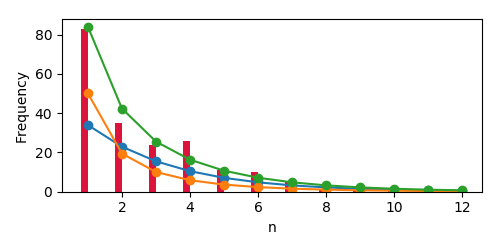

In [16]:
dist = results[1].estimated
fig = pyplot.figure(figsize=(5,2.5))
sum_dist = core.MixtureDistribution(dist.observations[0].sum,
                                    dist.observations[1].sum,
                                    pi = dist.pi)
axes = sum_dist.pdf_plot(axes = fig.add_subplot(111),
                         fmt = 'o-',
                         norm = sum_data.total,
                         qmin = sum_data.min.value,
                         qmax = sum_data.max.value,
                         states = [dict(fmt = '<--'),
                                   dict(fmt = '>--')])
axes = sum_data.pdf_plot(axes = axes, color='#e6e6e6')
axes.set_xlabel('n')
axes.set_ylabel('Frequency')
pyplot.tight_layout()
fig.savefig('sum.' + figure)

<IPython.core.display.Javascript object>


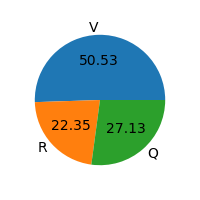

In [17]:
fig = pyplot.figure(figsize=(2,2))
rep_dist = core.OrdinalDistribution('V', 'R', 'Q', ordered_pi = dist.observations[0].pi)
axes = rep_dist.pdf_plot(axes = fig.add_subplot(111),
                         fmt = 'pie')
pyplot.tight_layout()
fig.savefig('pi_0.' + figure)

<IPython.core.display.Javascript object>


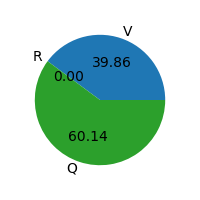

In [18]:
fig = pyplot.figure(figsize=(2,2))
rep_dist = core.OrdinalDistribution('V', 'R', 'Q', ordered_pi = dist.observations[1].pi)
axes = rep_dist.pdf_plot(axes = fig.add_subplot(111),
                         fmt = 'pie')
pyplot.tight_layout()
fig.savefig('pi_1.' + figure)